# **C-calculate_teleconnection.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 27th, 2023

Last modified: July 27th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# **<font color='red' size=5>0. download and import packages</font>**

In [14]:
import platform
if platform.system() == 'Linux':
    !pip install cdsapi --quiet
    !pip install imageio[ffmpeg] --quiet
    !pip install imageio[pyav] --quiet

In [15]:
# 1. downloaad
import cdsapi                         # download from Climate Data Store, ECMWF
import pooch, urllib.request          # download from any available URL
import s3fs, boto3, botocore          # download from S3 server, Amazon Web Service
from pythia_datasets import DATASETS  # download certain content from pythia

# 2. useful toolkits
from itertools import product
import os, sys, glob, time, tempfile

# 3. read and write
import h5py

# 4. data processing
from scipy import stats
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [16]:
second_per_day = 86400

# **<font color='red' size=5>1. read data</font>**

## **<font size=5>1.1. precipitation</font>**

### **<font size=4>Yang: option 1 is the file `precip.mon.mean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [4]:
# # data source 1: NCEP-NCAR v1
# ds_prcp = xr.open_dataset('/home/jovyan/shared/Data/Projects/ENSO/precip.mon.mean.nc')
# ds_prcp

### **<font size=4>Yang: option 2 is the ERA5 ReAnalysis Data under the folder `Data/ERA5/monthly/single_level/1979_2023_SM.nc` with time resolution of 1-month.</font>**

In [17]:
file_path = os.path.join('Data', 'ERA5', 'monthly', 'single_level', '1979-2023_SM.nc')
ds_prcp = xr.open_dataset(file_path).sel(expver=1).squeeze()
ds_prcp

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 101, time: 534)
Coordinates:
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 129.5 129.8 130.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -9.5 -9.75 -10.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-06-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    crr        (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    lsrr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-27 21:17:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## **<font size=5>1.2. ENSO Index</font>**

### **<font size=4>Yang: option 1: NOAA's ONI.</font>**

In [6]:
# # os.remove(os.path.join(tempfile.gettempdir(), 'detrend.nino34.ascii.txt'))
# file_path = pooch.retrieve(
#     url='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt', 
#     fname=os.path.join(tempfile.gettempdir(), 'detrend.nino34.ascii.txt'), 
#     known_hash=None, processor=None, 
# )
# with open(file_path, 'r+') as f:
#     content = f.read()
#     if '  ' in content:
#         new_content = content.replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace(' ', ',').replace(',YR', 'YR').replace('ANOM,', 'ANOM')
#         f.seek(0)
#         f.write(new_content)

# df = pd.read_csv(file_path, sep=',')
# index_to_delete = int(df.index[df['YR'] == '46'].values)
# df = df.drop(index=df.index[index_to_delete:])

# years  = df['YR'  ].values
# months = df['MON' ].values
# ONI    = df['ANOM'].values
# for i in range(len(years)):
#     if (years[i] == '1979')&(months[i] == 1):
#         start_idx = i
#     if (years[i] == '2023')&(months[i] == 5):
#         end_idx = i
# ds_oni = xr.Dataset({'oni': xr.DataArray(ONI[start_idx:(end_idx + 1)], coords=[pd.date_range(start='1979-01', end='2023-05', freq='MS')], dims=['time'])})
# ds_oni

### **<font size=4>Yang: option 2 is to calculate the ONI using the file `sst.mnmean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [18]:
# data source 1: NCEP-NCAR v1 SST
ds_sst = xr.open_dataset(os.sep + os.path.join('home', 'jovyan', 'shared', 'Data', 'Projects', 'ENSO', 'sst.mnmean.nc'))
ds_sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2034, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-07-03

### **<font size=4>Yang: option 3 is the ERA5 ReAnalysis Data under the folder `Data/ERA5/monthly/single_level/1979_2023_SM.nc` with time resolution of 1-month.</font>**

In [8]:
# file_path = os.path.join('Data', 'ERA5', 'monthly', 'single_level', '1979-2023_SM.nc')
# ds_sst = xr.open_dataset(file_path).sel(expver=1).squeeze()
# ds_sst

# **<font color='red' size=5>2. calculate ENSO teleconnections</font>**

### **<font size=5 color='blue'>ENSO</font>**

In [20]:
interested_region = [ 90.0, 130.0, -10.0, 15.0]
nino_region       = [190.0, 240.0,  -5.0,  5.0]

prcp = ds_prcp.crr.sel(time=slice('1979-01', '2023-05'), 
                       latitude=slice( interested_region[-1], interested_region[-2]), 
                       longitude=slice(interested_region[ 0], interested_region[ 1])) * second_per_day
sst_nino = ds_sst.sst.sel(time=slice('1979-01', '2023-05'), 
                          lat=slice(nino_region[-1], nino_region[-2]), 
                          lon=slice(nino_region[ 0], nino_region[ 1]))

prcp = prcp.sel(time=((prcp.time.dt.month==12)|(prcp.time.dt.month==1)|(prcp.time.dt.month==2)))
sst_nino = sst_nino.sel(time=((sst_nino.time.dt.month==12)|(sst_nino.time.dt.month==1)|(sst_nino.time.dt.month==2)))
print(prcp.time, sst_nino.time)

plon, plat = [], []

climatology = sst_nino.sel(time=slice('1981', '2010')).mean('time')
sst_anom_nino = sst_nino - climatology
sst_anom_series_nino = sst_anom_nino.mean(dim=['lon', 'lat'])

n, N, P = prcp.shape
r_field = np.zeros((N, P))
p_field = np.zeros((N, P))

for i in range(N):
    for j in range(P):
        r, p_val = stats.pearsonr(sst_anom_series_nino, prcp.isel(latitude=i, longitude=j).squeeze())
        r_field[i, j] = r
        # p_field[i, j] = p_val
        if p_val < 0.05:
            plat.append(prcp.latitude.values[i]), plon.append(prcp.longitude.values[j])
    print(f"{prcp.latitude.values[i]}° is done.")

plon, plat = np.array(plon), np.array(plat)

<xarray.DataArray 'time' (time: 134)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-12-01T00:00:00.000000000', '1980-01-01T00:00:00.000000000',
       '1980-02-01T00:00:00.000000000', '1980-12-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-12-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1982-02-01T00:00:00.000000000', '1982-12-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1983-02-01T00:00:00.000000000',
       '1983-12-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1984-02-01T00:00:00.000000000', '1984-12-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1985-02-01T00:00:00.000000000',
       '1985-12-01T00:00:00.000000000', '1986-01-01T00:00:00.000000000',
       '1986-02-01T00:00:00.000000000', '1986-12-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1987-02-01T00:00:00.000000000',
       '1987-

type: x and y must have the same length.

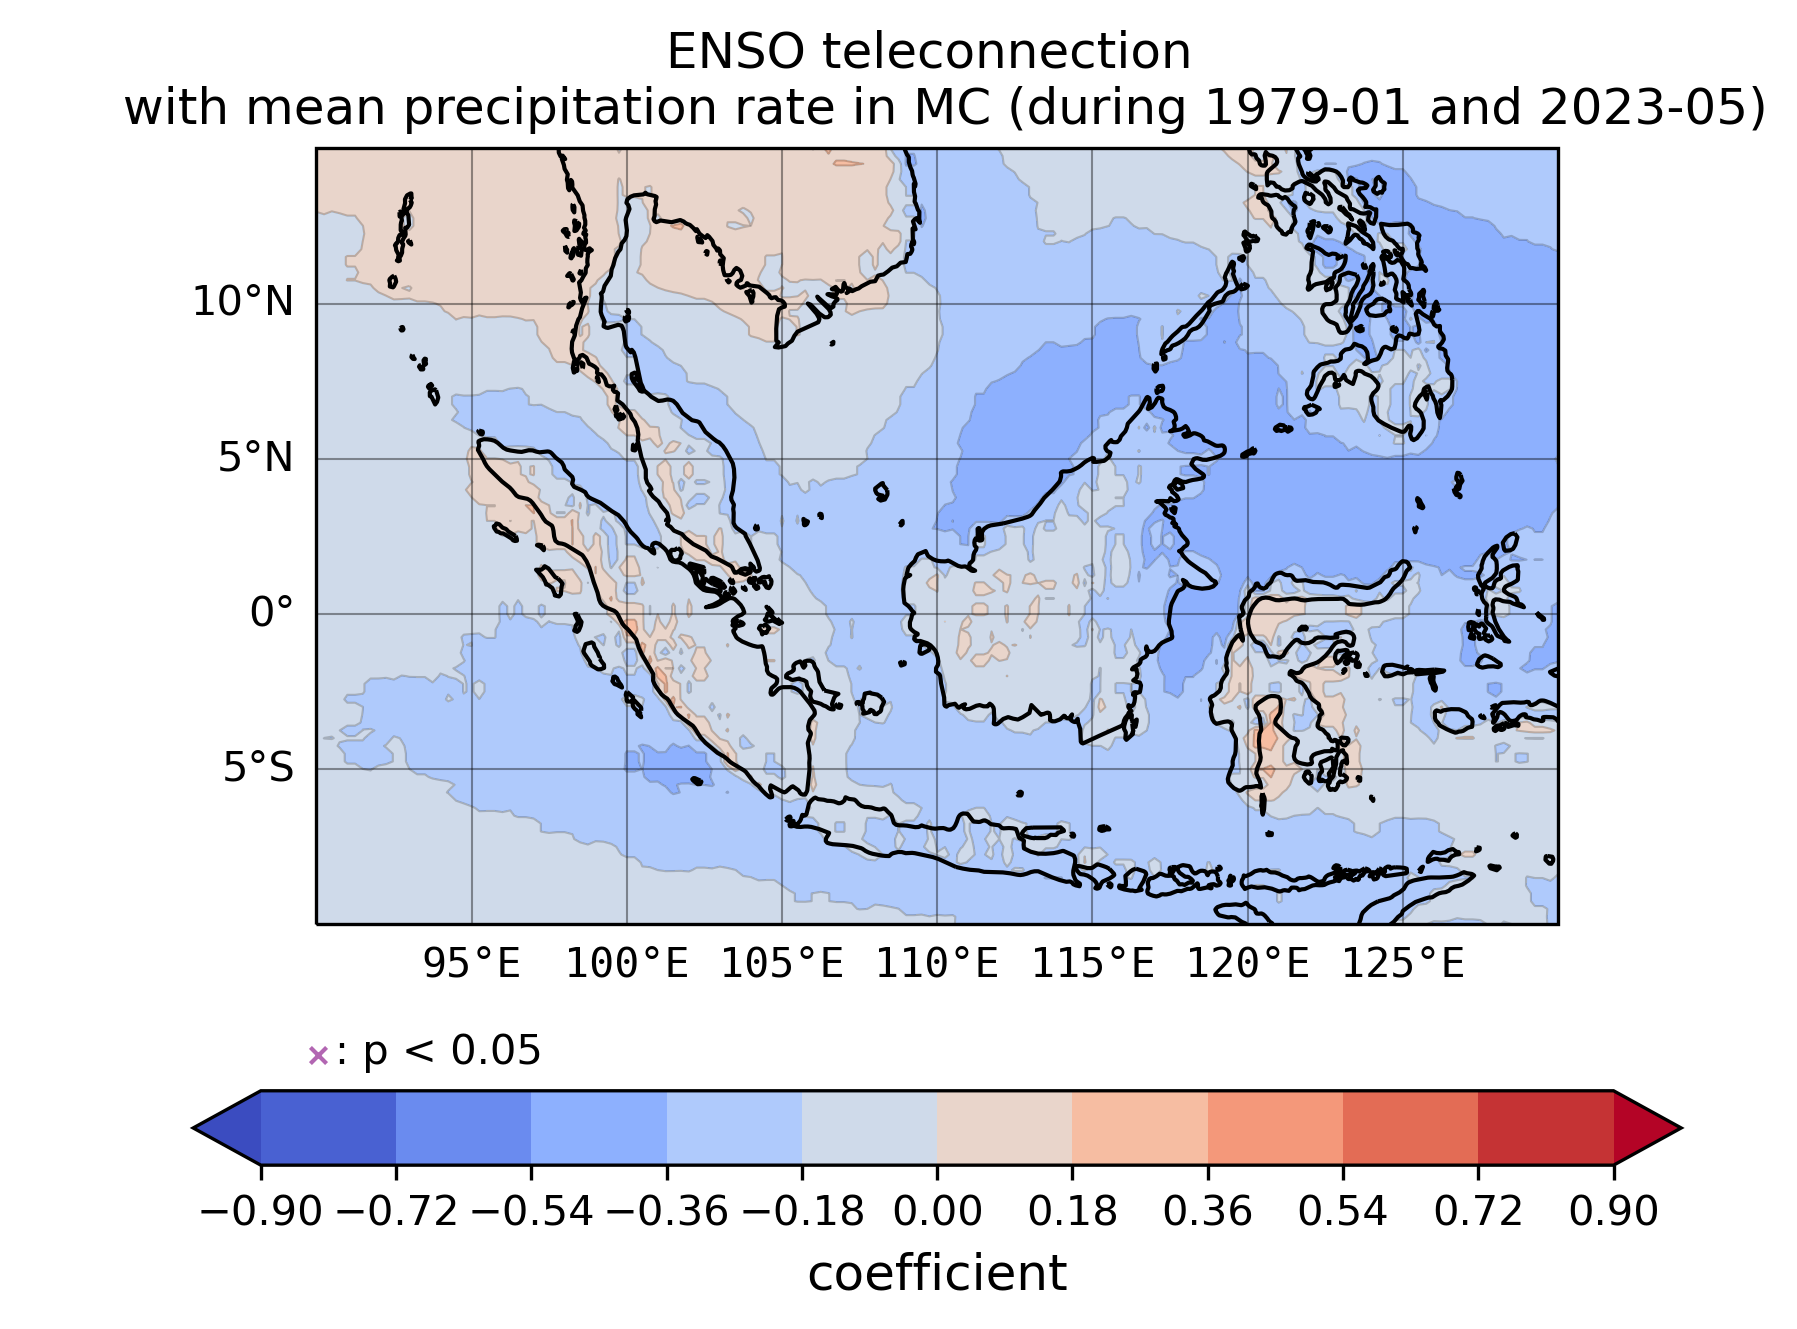

In [11]:
vmin, vmax = -0.9, 0.9
levels = np.linspace(vmin, vmax, 11)

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj}, dpi=300)
interested_region = [prcp.longitude.min(), prcp.longitude.max(), prcp.latitude.min(), prcp.latitude.max()]

ax.coastlines()
ax.set_extent(interested_region, crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.4, linewidth=0.5, linestyle='-')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.xlabel_style = {'family':'Monospace', 'size':10}, {'family':'Monospace', 'size':10}

im = ax.contourf(prcp.longitude, prcp.latitude, r_field, transform=ccrs.PlateCarree(), 
                 levels=levels, extend='both', cmap='coolwarm')
im1 = ax.contour(prcp.longitude, prcp.latitude, r_field, levels=im.levels, transform=ccrs.PlateCarree(), 
                 linestyles='-', linewidths=0.5, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=levels, orientation='horizontal')
cbar.set_label('coefficient', size=12)

ax.scatter(plon, plat, transform=ccrs.PlateCarree(), 
           s=3, marker="x", linewidths=0.5,
           c='purple', alpha=0.6)
ax1 = fig.add_axes([0.04, 0.2, 0.3, 0.1])
ax1.scatter(1, 1, s=15, marker="x", linewidth=1, c='purple', alpha=0.6)
ax1.axis('off')
ax1.text(0.53, 0.44, ': p < 0.05', transform=ax1.transAxes)

ax.set_title(f"ENSO teleconnection with mean precipitation rate \n during December-Feburuary in MC", fontdict={'size':12})

plt.savefig(os.path.join('Figure', 'MC_ENSO_telecon_with_prcp.png'), dpi=300)

# **<font color='red' size=5>3. ENSO teleconnections during El Niño and La Niña periods</font>**

In [16]:
interested_region = [ 90.0, 130.0, -10.0, 15.0]
nino_region       = [190.0, 240.0, -5.0 ,  5.0]

prcp = ds_prcp.crr.sel(latitude=slice( interested_region[-1], interested_region[-2]), 
                       longitude=slice(interested_region[ 0], interested_region[ 1]))
sst_nino = ds_sst.sst.sel(lat=slice(nino_region[-1], nino_region[-2]), 
                          lon=slice(nino_region[ 0], nino_region[ 1]))

In [17]:
# step 1
E_timeidx = np.array([['1982-04', '1983-06'],
                      ['1986-04', '1988-04'],
                      ['1991-11', '1992-06'],
                      ['1997-04', '1998-05'],
                      ['2002-03', '2003-07'],
                      ['2004-03', '2005-06'],
                      ['2009-04', '2010-05'],
                      ['2015-03', '2016-06'],
                      ['2019-02', '2019-07']])
L_timeidx = np.array([['1980-08', '1981-02'],
                      ['1981-08', '1982-02'],
                      ['1983-08', '1984-02'],
                      ['1985-08', '1986-02'],
                      ['1988-06', '1989-03'],
                      ['1989-07', '1990-01'],
                      ['1992-08', '1993-01'],
                      ['1995-08', '1996-03'],
                      ['1996-08', '1997-02'],
                      ['1998-07', '1999-04'],
                      ['1999-07', '2000-03'],
                      ['2000-08', '2001-02'],
                      ['2007-08', '2008-03'],
                      ['2008-09', '2009-02'],
                      ['2010-07', '2011-03'],
                      ['2011-08', '2012-02'],
                      ['2013-08', '2014-02'],
                      ['2016-08', '2017-01'],
                      ['2017-09', '2018-03'],
                      ['2020-08', '2021-03'],
                      ['2021-08', '2022-03'],
                      ['2022-07', '2023-02']])

sst_E_nino = sst_nino.sel(time=slice(E_timeidx[0][0], E_timeidx[0][1]))
prcp_E     = prcp.sel(    time=slice(E_timeidx[0][0], E_timeidx[0][1]))
sst_L_nino = sst_nino.sel(time=slice(L_timeidx[0][0], L_timeidx[0][1]))
prcp_L     = prcp.sel(    time=slice(L_timeidx[0][0], L_timeidx[0][1]))

for i in range(1, E_timeidx.shape[0]):
    sst_E_nino = xr.concat([sst_E_nino , sst_nino.sel(time=slice(E_timeidx[i][0], E_timeidx[i][1]))], dim='time')
    prcp_E     = xr.concat([prcp_E     , prcp.sel(    time=slice(E_timeidx[i][0], E_timeidx[i][1]))], dim='time')
for i in range(1, L_timeidx.shape[0]):
    sst_L_nino = xr.concat([sst_L_nino , sst_nino.sel(time=slice(L_timeidx[i][0], L_timeidx[i][1]))], dim='time')
    prcp_L     = xr.concat([prcp_L     , prcp.sel(    time=slice(L_timeidx[i][0], L_timeidx[i][1]))], dim='time')

In [18]:
climatology = sst_nino.sel(time=slice('1981', '2010')).mean('time')

sst_anom_E_nino        = sst_E_nino - climatology
sst_anom_series_E_nino = sst_anom_E_nino.mean(dim=['lon', 'lat'])
sst_anom_L_nino        = sst_L_nino - climatology
sst_anom_series_L_nino = sst_anom_L_nino.mean(dim=['lon', 'lat'])

In [20]:
prcp_E = prcp_E.sel(                                time=((                prcp_E.time.dt.month==12)|(                prcp_E.time.dt.month==1)|(                prcp_E.time.dt.month==2)))
sst_anom_series_E_nino = sst_anom_series_E_nino.sel(time=((sst_anom_series_E_nino.time.dt.month==12)|(sst_anom_series_E_nino.time.dt.month==1)|(sst_anom_series_E_nino.time.dt.month==2)))
prcp_L = prcp_L.sel(                                time=((                prcp_L.time.dt.month==12)|(                prcp_L.time.dt.month==1)|(                prcp_L.time.dt.month==2)))
sst_anom_series_L_nino = sst_anom_series_L_nino.sel(time=((sst_anom_series_L_nino.time.dt.month==12)|(sst_anom_series_L_nino.time.dt.month==1)|(sst_anom_series_L_nino.time.dt.month==2)))

### **<font size=5 color='blue'>El Niño</font>**

In [26]:
# El Niño
n, N, P = prcp_E.shape
r_field_E = np.zeros((N, P))
p_field_E = np.zeros((N, P))
plon_E, plat_E = [], []

for i in range(N):
    for j in range(P):
        r, p_val = stats.pearsonr(sst_anom_series_E_nino, prcp_E.isel(latitude=i, longitude=j).squeeze())
        r_field_E[i, j] = r
        # p_field_E[i, j] = p_val
        if p_val < 0.05:
            plat_E.append(prcp_E.latitude.values[i]), plon_E.append(prcp_E.longitude.values[j])
    print(f"{prcp_E.latitude.values[i]}° is done.")

plon_E, plat_E = np.array(plon_E), np.array(plat_E)

15.0° is done.
14.75° is done.
14.5° is done.
14.25° is done.
14.0° is done.
13.75° is done.
13.5° is done.
13.25° is done.
13.0° is done.
12.75° is done.
12.5° is done.
12.25° is done.
12.0° is done.
11.75° is done.
11.5° is done.
11.25° is done.
11.0° is done.
10.75° is done.
10.5° is done.
10.25° is done.
10.0° is done.
9.75° is done.
9.5° is done.
9.25° is done.
9.0° is done.
8.75° is done.
8.5° is done.
8.25° is done.
8.0° is done.
7.75° is done.
7.5° is done.
7.25° is done.
7.0° is done.
6.75° is done.
6.5° is done.
6.25° is done.
6.0° is done.
5.75° is done.
5.5° is done.
5.25° is done.
5.0° is done.
4.75° is done.
4.5° is done.
4.25° is done.
4.0° is done.
3.75° is done.
3.5° is done.
3.25° is done.
3.0° is done.
2.75° is done.
2.5° is done.
2.25° is done.
2.0° is done.
1.75° is done.
1.5° is done.
1.25° is done.
1.0° is done.
0.75° is done.
0.5° is done.
0.25° is done.
0.0° is done.
-0.25° is done.
-0.5° is done.
-0.75° is done.
-1.0° is done.
-1.25° is done.
-1.5° is done.
-1

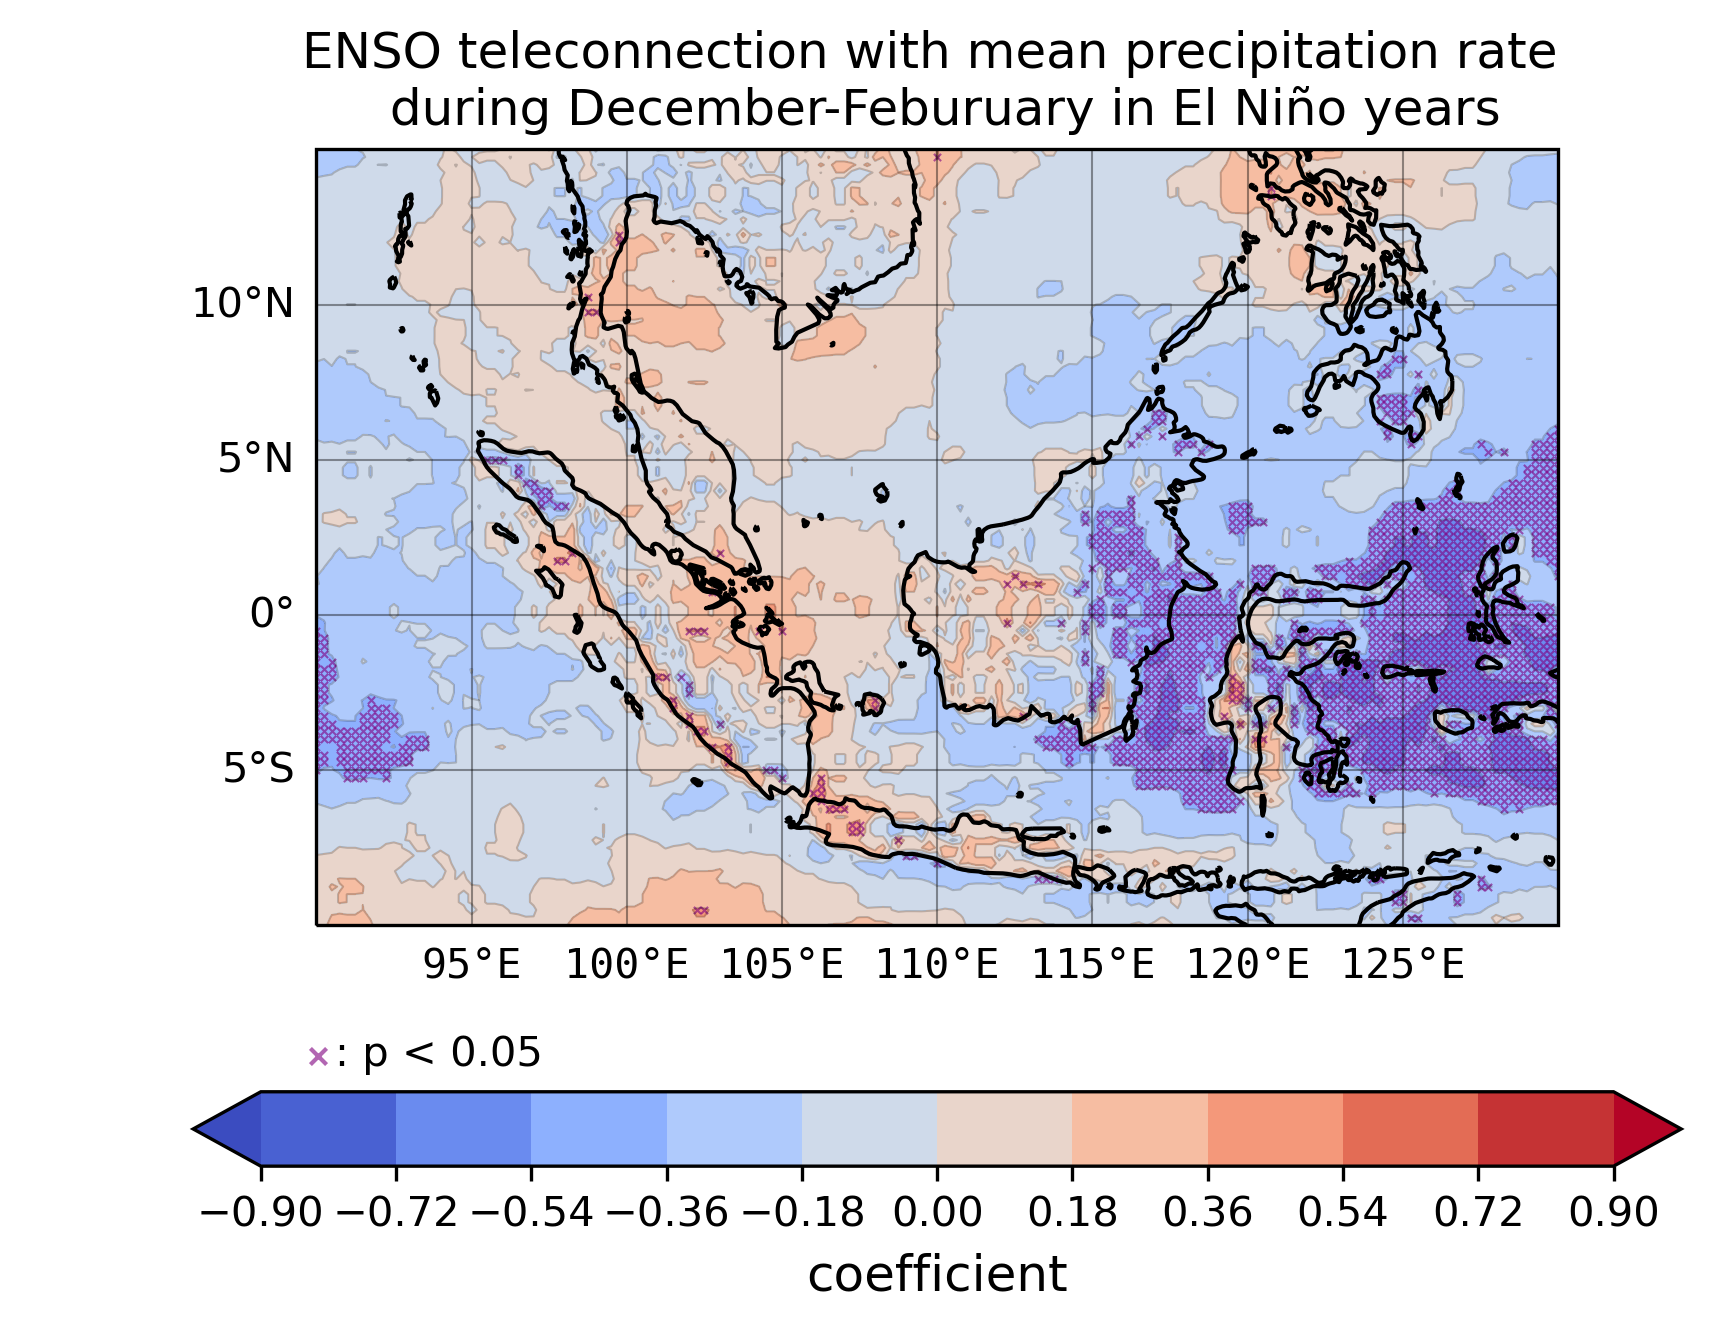

In [57]:
vmin, vmax = -0.9, 0.9
levels = np.linspace(vmin, vmax, 11)

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj}, dpi=300)
interested_region = [prcp_E.longitude.min(), prcp_E.longitude.max(), prcp_E.latitude.min(), prcp_E.latitude.max()]

ax.coastlines()
ax.set_extent(interested_region, crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.4, linewidth=0.5, linestyle='-')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.xlabel_style = {'family':'Monospace', 'size':10}, {'family':'Monospace', 'size':10}

im = ax.contourf(prcp_E.longitude, prcp_E.latitude, r_field_E, transform=ccrs.PlateCarree(), 
                 levels=levels, extend='both', cmap='coolwarm')
im1 = ax.contour(prcp_E.longitude, prcp_E.latitude, r_field_E, levels=im.levels, transform=ccrs.PlateCarree(), 
                 linestyles='-', linewidths=0.5, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=levels, orientation='horizontal')
cbar.set_label('coefficient', size=12)

ax.scatter(plon_E, plat_E, transform=ccrs.PlateCarree(), 
           s=3, marker="x", linewidths=0.5,
           c='purple', alpha=0.6)
ax1 = fig.add_axes([0.04, 0.2, 0.3, 0.1])
ax1.scatter(1, 1, s=15, marker="x", linewidth=1, c='purple', alpha=0.6)
ax1.axis('off')
ax1.text(0.53, 0.44, ': p < 0.05', transform=ax1.transAxes)

ax.set_title(f"ENSO teleconnection with mean precipitation rate \n during December-Feburuary in El Niño years", fontdict={'size':12})

plt.savefig(os.path.join('Figure', 'MC_El_Niño_telecon_with_prcp.png'), dpi=300)

### **<font size=5 color='blue'>La Niña</font>**

In [49]:
# La Niña
n, N, P = prcp_L.shape
r_field_L = np.zeros((N, P))
p_field_L = np.zeros((N, P))
plon_L, plat_L = [], []

for i in range(N):
    for j in range(P):
        r, p_val = stats.pearsonr(sst_anom_series_L_nino, prcp_L.isel(latitude=i, longitude=j).squeeze())
        r_field_L[i, j] = r
        # p_field_L[i, j] = p_val
        if p_val < 0.05:
            plat_L.append(prcp_L.latitude.values[i]), plon_L.append(prcp_L.longitude.values[j])
    print(f"{prcp_L.latitude.values[i]}° is done.")

15.0° is done.
14.75° is done.
14.5° is done.
14.25° is done.
14.0° is done.
13.75° is done.
13.5° is done.
13.25° is done.
13.0° is done.
12.75° is done.
12.5° is done.
12.25° is done.
12.0° is done.
11.75° is done.
11.5° is done.
11.25° is done.
11.0° is done.
10.75° is done.
10.5° is done.
10.25° is done.
10.0° is done.
9.75° is done.
9.5° is done.
9.25° is done.
9.0° is done.
8.75° is done.
8.5° is done.
8.25° is done.
8.0° is done.
7.75° is done.
7.5° is done.
7.25° is done.
7.0° is done.
6.75° is done.
6.5° is done.
6.25° is done.
6.0° is done.
5.75° is done.
5.5° is done.
5.25° is done.
5.0° is done.
4.75° is done.
4.5° is done.
4.25° is done.
4.0° is done.
3.75° is done.
3.5° is done.
3.25° is done.
3.0° is done.
2.75° is done.
2.5° is done.
2.25° is done.
2.0° is done.
1.75° is done.
1.5° is done.
1.25° is done.
1.0° is done.
0.75° is done.
0.5° is done.
0.25° is done.
0.0° is done.
-0.25° is done.
-0.5° is done.
-0.75° is done.
-1.0° is done.
-1.25° is done.
-1.5° is done.
-1

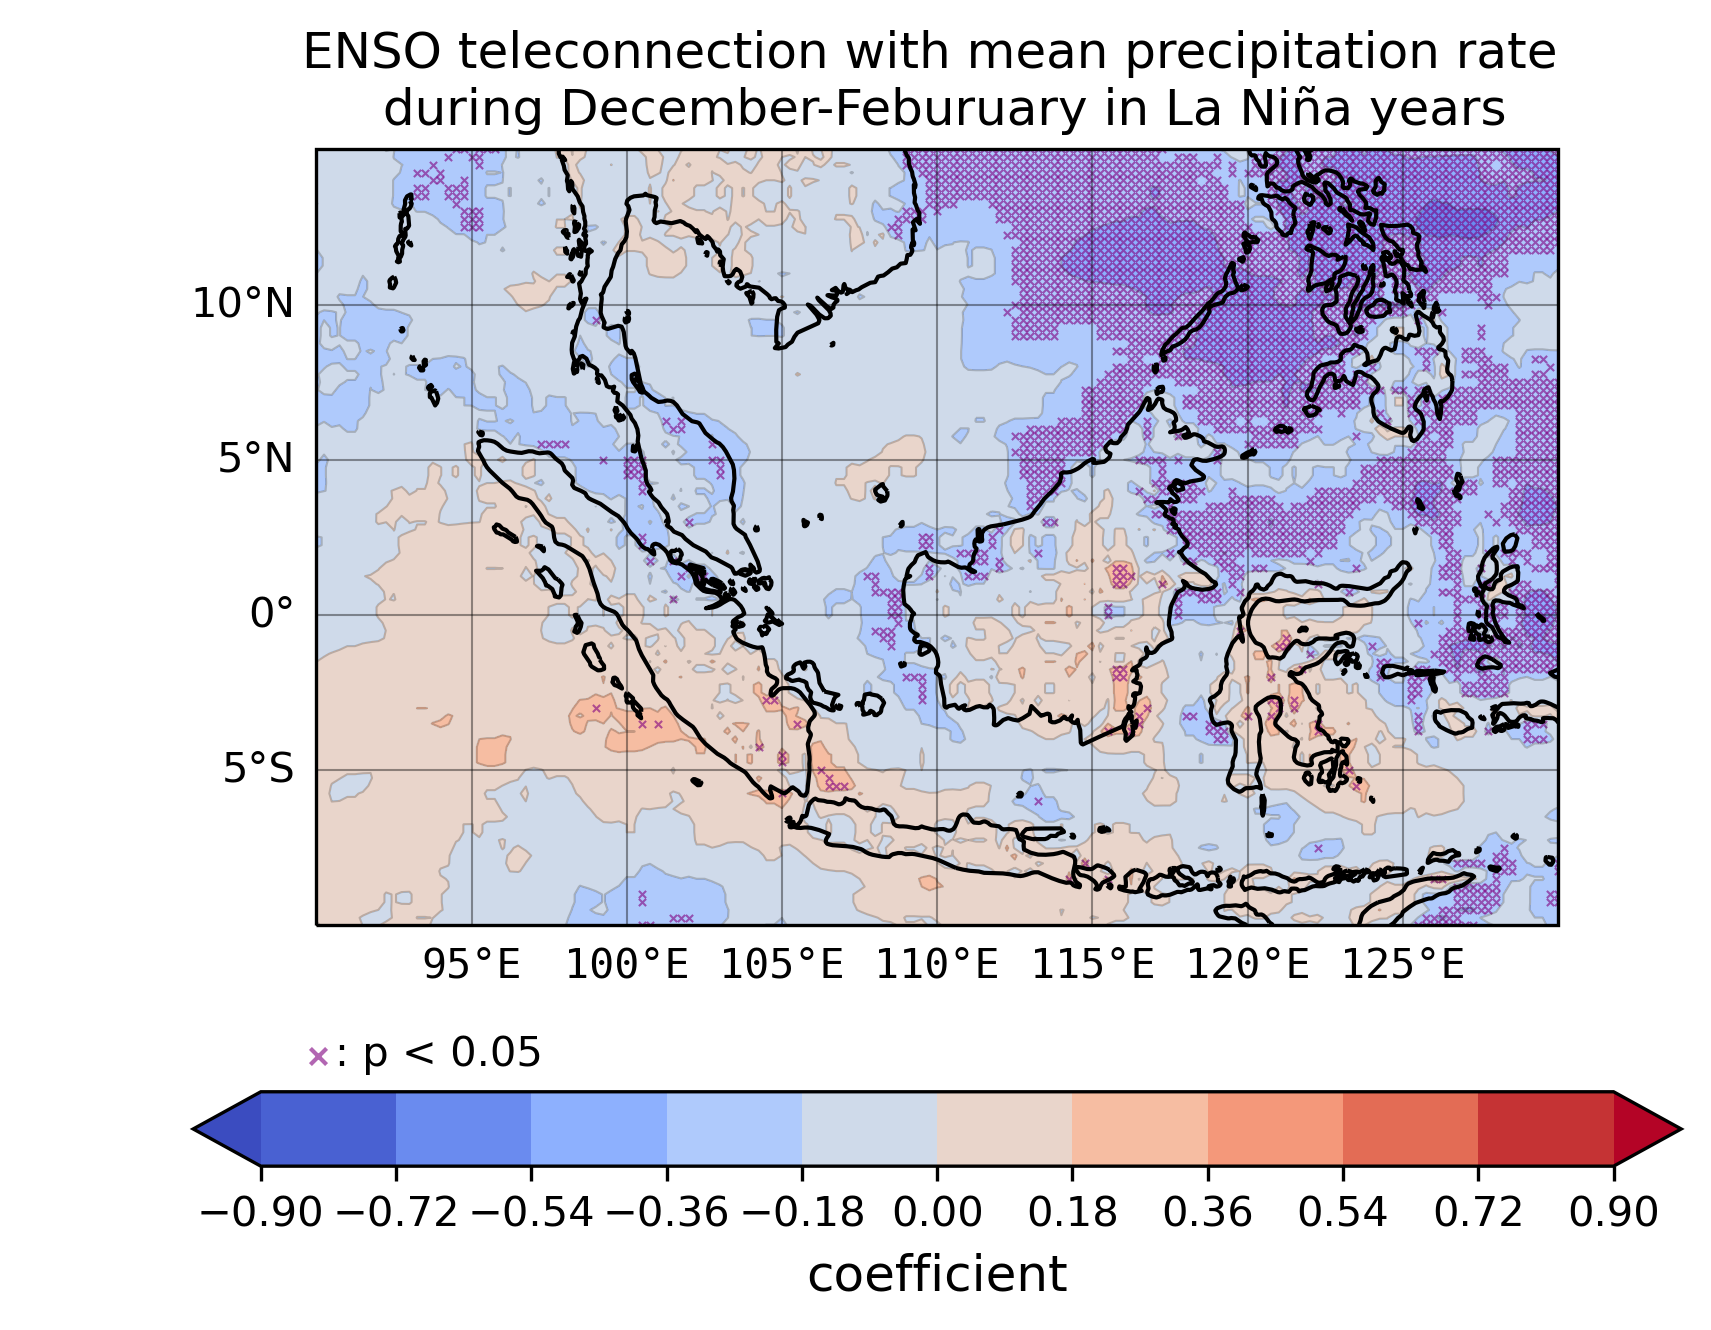

In [58]:
vmin, vmax = -0.9, 0.9
levels = np.linspace(vmin, vmax, 11)

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj}, dpi=300)
interested_region = [prcp_L.longitude.min(), prcp_L.longitude.max(), prcp_L.latitude.min(), prcp_L.latitude.max()]

ax.coastlines()
ax.set_extent(interested_region, crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.4, linewidth=0.5, linestyle='-')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.xlabel_style = {'family':'Monospace', 'size':10}, {'family':'Monospace', 'size':10}

im = ax.contourf(prcp_L.longitude, prcp_L.latitude, r_field_L, transform=ccrs.PlateCarree(), 
                 levels=levels, extend='both', cmap='coolwarm')
im1 = ax.contour(prcp_L.longitude, prcp_L.latitude, r_field_L, levels=im.levels, transform=ccrs.PlateCarree(), 
                 linestyles='-', linewidths=0.5, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=levels, orientation='horizontal')
cbar.set_label('coefficient', size=12)

ax.scatter(plon_L, plat_L, transform=ccrs.PlateCarree(), 
           s=3, marker="x", linewidths=0.5,
           c='purple', alpha=0.6)
ax1 = fig.add_axes([0.04, 0.2, 0.3, 0.1])
ax1.scatter(1, 1, s=15, marker="x", linewidth=1, c='purple', alpha=0.6)
ax1.axis('off')
ax1.text(0.53, 0.44, ': p < 0.05', transform=ax1.transAxes)

ax.set_title(f"ENSO teleconnection with mean precipitation rate \n during December-Feburuary in La Niña years", fontdict={'size':12})

plt.savefig(os.path.join('Figure', 'MC_La_Niña_telecon_with_prcp.png'), dpi=300)